In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

In [150]:
train = pd.read_csv('train.csv')
org = pd.read_csv('ParisHousing.csv')

train = pd.concat([train, org])

test = pd.read_csv('test.csv')
ids = test['id']

train = train.drop(columns = ['id', 'cityCode'])
test = test.drop(columns = ['id', 'cityCode'])

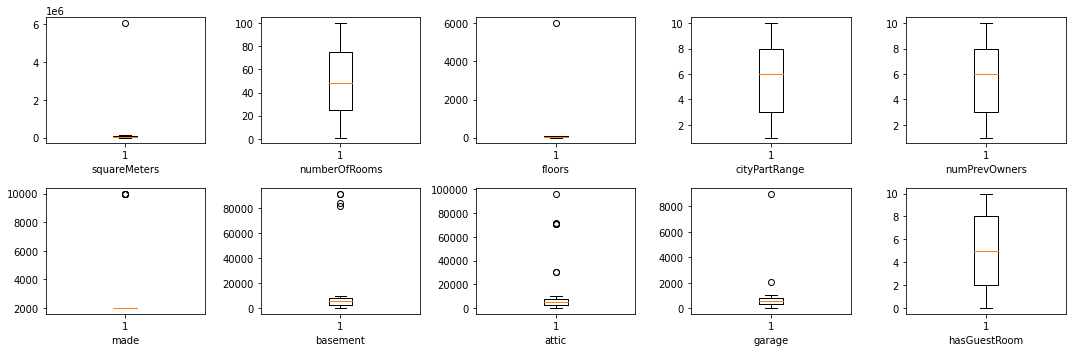

In [151]:
categorical = ['hasYard', 'hasPool', 'isNewBuilt', 'hasStormProtector', 'hasStorageRoom']
numerical = train.drop(columns = categorical).columns[:-1]

rows = ceil(len(numerical) / 5)
fig, axes = plt.subplots(rows, 5, figsize = (15, rows*2.5))
axes = axes.flatten()

for i, col in enumerate(numerical):
    axes[i].boxplot(train[col])
    axes[i].set_xlabel(col)
plt.tight_layout()

In [152]:
Q1 = train[numerical].quantile(0.25)
Q3 = train[numerical].quantile(0.75)
IQS = Q3 - Q1

outliers = ((train[IQS.index] < Q1 - 1.5*IQS) | (train[IQS.index] > Q3 + 1.5*IQS)).any(axis=1)
print(len(train))
train = train[~outliers]
print(len(train))

32730
32710


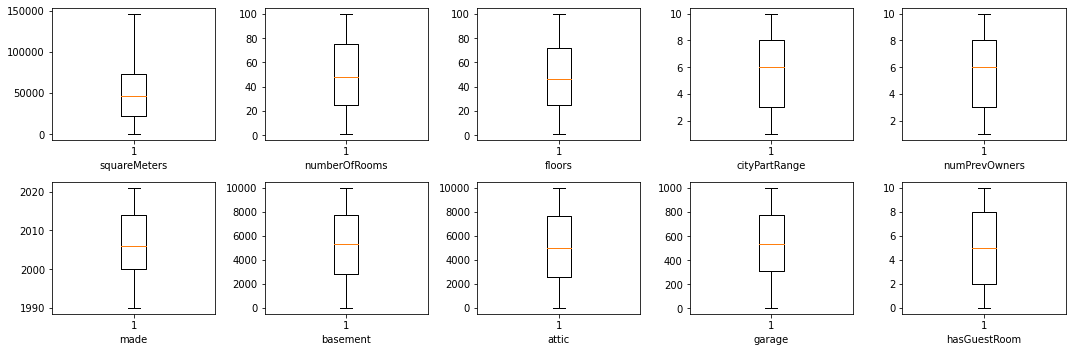

In [153]:
fig, axes = plt.subplots(rows, 5, figsize = (15, rows*2.5))
axes = axes.flatten()

for i, col in enumerate(numerical):
    axes[i].boxplot(train[col])
    axes[i].set_xlabel(col)
plt.tight_layout()

In [113]:
df = pd.concat([train, test])
df = df.reset_index(drop=True)

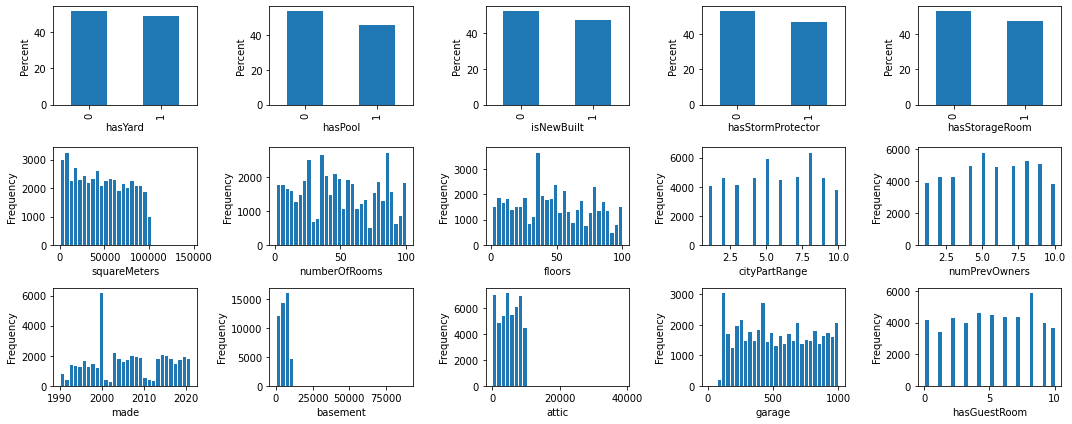

In [114]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(categorical):
    (100* df[col].value_counts() / len(df)).plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percent')
    
for i, col in enumerate(numerical):
    j = i+len(categorical)
    
    df[col].plot.hist(ax = axes[j], bins = 30, edgecolor='white')
    axes[j].set_xlabel(col)
    
plt.tight_layout()

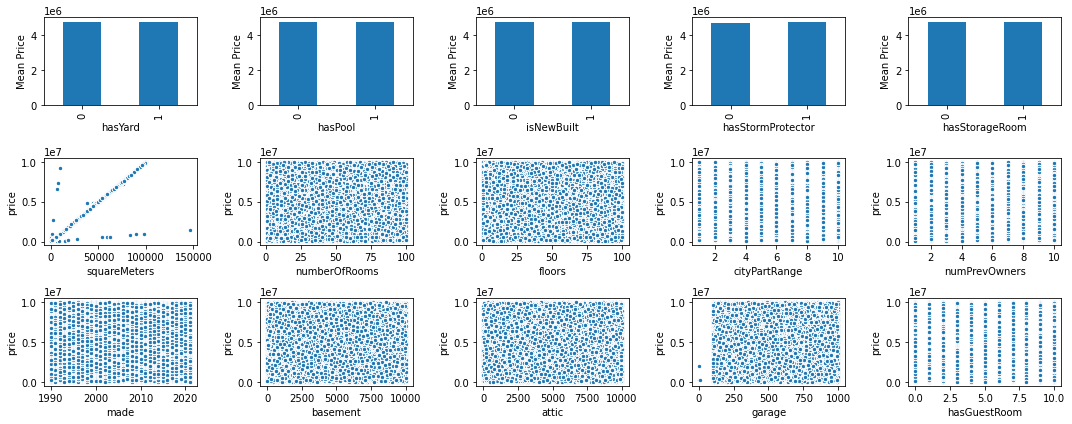

In [115]:
fig, axes = plt.subplots(3, 5, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(categorical):
    df.groupby(col)['price'].mean().plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Mean Price")
    
for i, col in enumerate(numerical):
    j = i+len(categorical)
    
    df.plot.scatter(x=col, y='price', ax = axes[j], edgecolor='white')
    axes[j].set_xlabel(col)
    
plt.tight_layout()

In [116]:
df_dummy = pd.get_dummies(df)

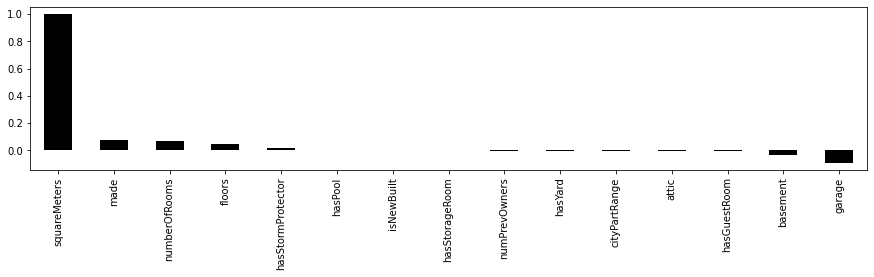

In [117]:
df_dummy.corr()['price'].sort_values(ascending=False)[1:].plot.bar(figsize=(15,3), cmap='copper')
plt.show()

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummy.drop(columns='price')
y = df_dummy['price']

features = X.columns.values

Scaler = StandardScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns = features)

X_test = X[len(train):]
X = X.iloc[:len(train)]
y = y.iloc[:len(train)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [133]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train, y_train)

print("Training score: ", model.score(X_train, y_train))
print("Validation score: ", model.score(X_valid, y_valid))

Training score:  0.9976214419095917
Validation score:  0.9941381621512769


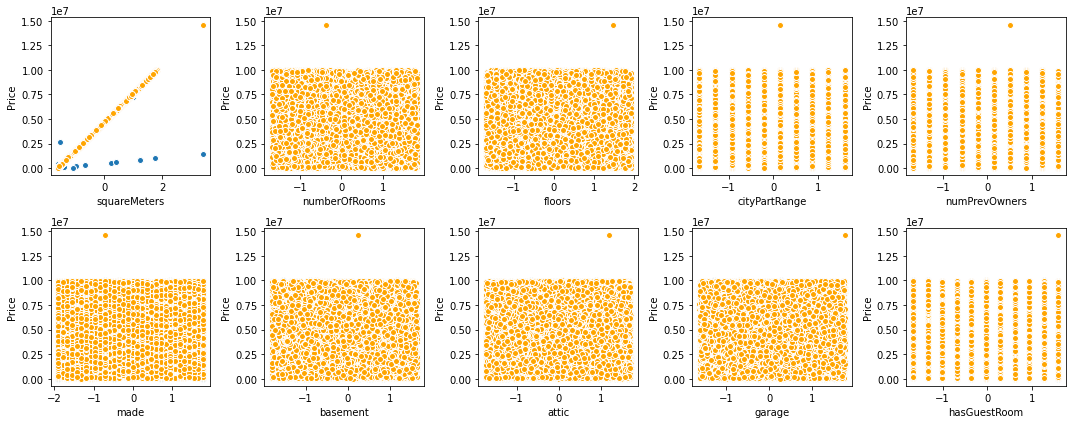

In [134]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for j, col in enumerate(numerical):
    axes[j].scatter(X_valid[col], y_valid, edgecolor='white')
    axes[j].scatter(X_valid[col], model.predict(X_valid), edgecolor='white', color='orange')
    axes[j].set_xlabel(col)
    axes[j].set_ylabel("Price")

plt.tight_layout()

In [135]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

print("Training score: ", model.score(X_train, y_train))
print("Validation score: ", model.score(X_valid, y_valid))

Training score:  0.9999630012357641
Validation score:  0.9959886404723169


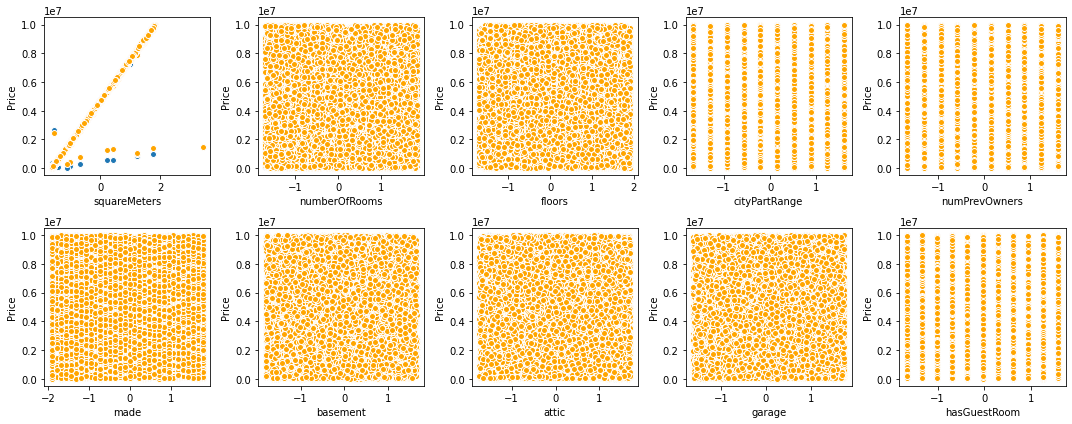

In [140]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for j, col in enumerate(numerical):
    axes[j].scatter(X_valid[col], y_valid, edgecolor='white')
    axes[j].scatter(X_valid[col], model.predict(X_valid), edgecolor='white', color='orange')
    axes[j].set_xlabel(col)
    axes[j].set_ylabel("Price")
    
plt.tight_layout()

In [137]:
final_model = XGBRegressor()
final_model.fit(X, y)
print("Training score: ", final_model.score(X, y))
y_test_pred = final_model.predict(X_test)

Training score:  0.9999476037427933


In [138]:
output = pd.DataFrame({'id': ids, 'price': y_test_pred})

In [141]:
output.to_csv("Submission.csv", index=False)